In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import lambertw
import csv
import os
from os import listdir
from os.path import isfile, join

def clean_raw_data(iv_folder, iv_file, vmin, vmax):
    
    """Cleans a txt file with voltage and current data."""
    
    data = np.loadtxt(iv_folder + "/" + iv_file, usecols=(0, 1))
    
    # Find the indices of entries where voltage is 0
    zero_voltage_indices = np.where(data[:, 0] == 0)[0]

    # If there are duplicates at voltage 0, remove one of each pair
    if len(zero_voltage_indices) > 1:
        # Remove the first duplicate (assuming they are consecutive)
        data = np.delete(data, zero_voltage_indices[0], axis=0)

    # Sort the data from reverse to forward bias (sort by voltage in ascending order)
    truncated_data = data[(data[:, 0] >= vmin) & (data[:, 0] <= vmax)]
    sorted_data_reverse_to_forward = truncated_data[truncated_data[:, 0].argsort()]
    
    # Separate the re-sorted data into voltage and current arrays
    voltage = sorted_data_reverse_to_forward[:, 0]
    current = sorted_data_reverse_to_forward[:, 1]
    
    return voltage, current
    
def load_result_file(results_folder, results_file):
    """Load a txt file with results from several optimization runs"""
    df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
    df.set_index('Run', inplace=True)
    df.index = df.index.astype(int)
    return df   

def calculate_mape(actual, forecast):    
    n = len(actual)
    mape = 100*sum(abs((a - f) / a) for a, f in zip(actual, forecast))/n
    return mape

def lambertw_newton(z, tol=1e-10, max_iter=100):
    w = np.log(z + 1)  # Initial guess
    for i in range(max_iter):
        ew = np.exp(w)
        w_next = w - (w * ew - z) / (ew + w * ew)
        if np.all(np.abs(w_next - w) < tol):
            return w_next
        w = w_next
    return w  # Return the last approximation if convergence criteria are not met

def results(temperature_celsius, iv_folder, iv_file, results_folder, results_file, plot=False, save=False):
    area = 3.14*(0.1/2)**2
    voltage, current = clean_raw_data(iv_folder, iv_file, vmin, vmax)
    df = load_result_file(results_folder, results_file)
    best_result = df.loc[df['Objective'].idxmin()]
    charge = 1.60e-19
    boltz = 1.38e-23
    vt = boltz * (temperature_celsius + 273.15) / charge
    objective, i0, n, Rs, Rsh, offset = best_result
    indv = [i0, n, Rs, Rsh, offset]
    print(best_result)
    adjusted_voltage = voltage + indv[4]
    term1 = 1.0 + indv[2] / indv[3]
    term2 = (indv[0] * indv[2]) / (indv[1] * vt * term1)
    term3 = (indv[2] * indv[0] + adjusted_voltage) / (indv[1] * vt * term1)  # V is now an array, so this operation is vectorized
    sim = (indv[1] * vt / indv[2]) * lambertw_newton(term2 * np.exp(term3)) - (indv[0] - adjusted_voltage / indv[3]) / term1
    mape = calculate_mape(sim,current)
    print(f"MAPE: {mape:.2f} %")
    if plot:
        plt.plot(voltage,np.abs(current/area), 'o', color='lightblue', label="Exp. data: " + str(temperature_celsius) + u"\u00b0 C" )
        plt.plot(voltage,np.abs(sim/area), '-' ,color = '#FF6347', label = "Fit")
        plt.yscale("log")
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current density ($A\,cm^{-2}$)')
    if save:
        plt.tight_layout()
        plt.savefig('figures/IV_fit_temp.pdf', format='pdf', dpi=600, bbox_inches='tight')
    plt.show()
        #plt.close()
        
plt.rcParams.update({'font.size': 16})

iv_curve_500.txt
Objective   9.349e-02
I0          1.069e-06
n           1.262e+00
Rs          1.766e+01
Rsh         4.693e+04
Offset      1.611e-03
Name: 0, dtype: float64
MAPE: 7.83 %


C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)


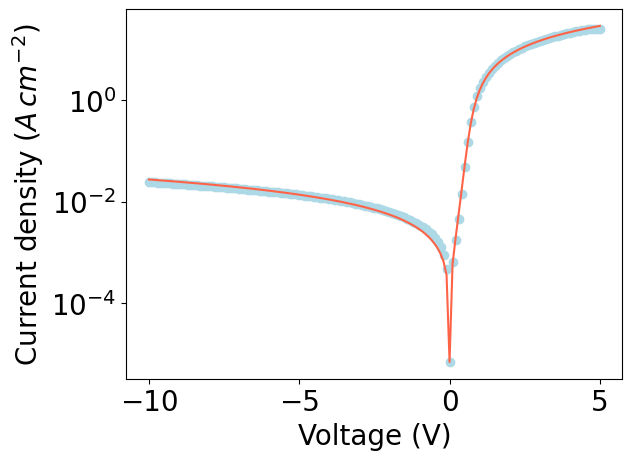

In [15]:
# %matplotlib qt 
pd.set_option('display.float_format', lambda x: '%.3e' % x)
temperature_celsius = 500
vmin, vmax = -10, 5

iv_folder = "./D2_Temp/"+str(temperature_celsius)+"C/"
iv_curves = [f for f in listdir(iv_folder) if isfile(join(iv_folder, f))]
iv_filename = iv_curves[0]
print(iv_filename)

results_folder = iv_folder + "/Results"
results_file = "Results_" + iv_filename

results(temperature_celsius, iv_folder, iv_filename, results_folder, results_file, plot=True,save=False)

In [6]:
from scipy import stats
folder_list = [300,350,400,450,500,550]
i0 = []
n = []
Rs = []
Rsh = []
for folder in folder_list:
    iv_folder = "./D2_Temp/" + str(folder) +"C"
    results_folder = iv_folder + "/Results"
    iv_curves = [f for f in listdir(iv_folder) if isfile(join(iv_folder, f))]
    iv_filename = iv_curves[0]    
    results_file = "Results_" + iv_filename
    df = load_result_file(results_folder, results_file)
    best_result = df.loc[df['Objective'].idxmin()]
    i0.append(best_result["I0"])
    n.append(best_result["n"])
    Rs.append(best_result["Rs"])
    Rsh.append(best_result["Rsh"])
i0 = np.array(i0)
n = np.array(n)
Rs = np.array(Rs)
Rsh = np.array(Rsh)

C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\62138

R-squared: 0.951
Phi: 1.09


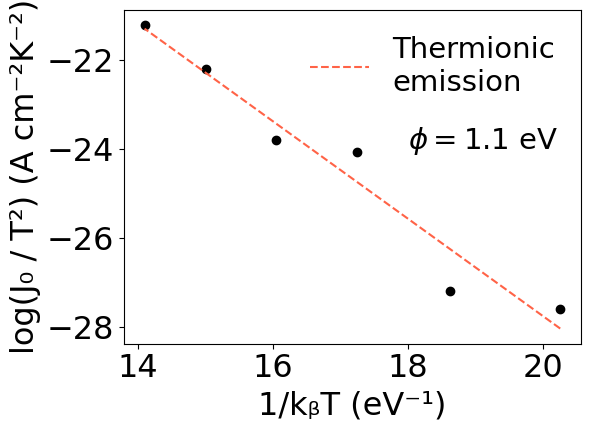

In [33]:
from scipy import stats
plt.rcParams.update({'font.size': 23})
area = 3.14*(0.1/2)**2

temperatures = np.array([(temp + 273.15) for temp in folder_list])
k_B = 8.617e-5  # eV/K
x_axis = 1/(k_B*temperatures)
y_axis = np.log((i0/area)/(temperatures**2))

res = stats.linregress(x_axis, y_axis)
fitted_values = res.intercept + res.slope*x_axis

plt.plot(x_axis, y_axis, 'ko')
plt.plot(x_axis, fitted_values, '--', color = '#FF6347', label='Thermionic\nemission')
plt.text(18, -24, '$\phi=1.1$ eV', fontsize=21)
#plt.text(18, -24, '$R^2=0.95$', fontsize=16)
plt.legend(frameon=False,loc='upper right',fontsize=21)
phi = -res.slope
print(f"R-squared: {res.rvalue**2:.3f}")
print(f"Phi: {phi:.2f}")
plt.xlabel('1/kᵦT (eV⁻¹)')
plt.ylabel('log(J₀ / T²) (A cm⁻²K⁻²)')
plt.tight_layout()
plt.savefig('../LLM/Figures/thermionic.png', format='png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

In [70]:
res.intercept

-8.279822102393272

In [ ]:
from scipy import stats
temperatures = np.array([(temp) for temp in folder_list])
area = 3.14*(0.1/2)**2
x_axis = temperatures
y_axis = i0
plt.plot(x_axis, y_axis/area, 'o', label='Exp. Data')
plt.legend(frameon=False)
plt.yscale('log')
#plt.ylim(1,2)
plt.xlabel('Temperature (C)')
plt.ylabel('Reverse saturation current ($A\,cm^{-2}$)')
plt.tight_layout()
#plt.savefig("I0_T.png",format="png",dpi=600)
plt.show()

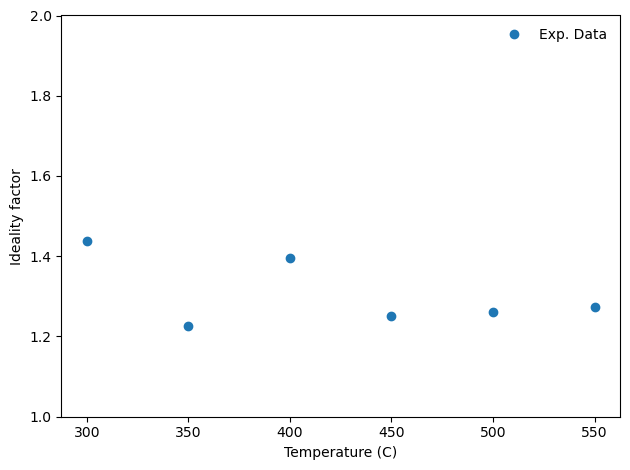

In [11]:
from scipy import stats
temperatures = np.array([(temp) for temp in folder_list])
x_axis = temperatures
y_axis = n
plt.plot(x_axis, y_axis, 'o', label='Exp. Data')
plt.legend(frameon=False)
plt.ylim(1,2)
plt.xlabel('Temperature (C)')
plt.ylabel('Ideality factor')
plt.tight_layout()
plt.savefig("n.png",format="png",dpi=600)
plt.show()

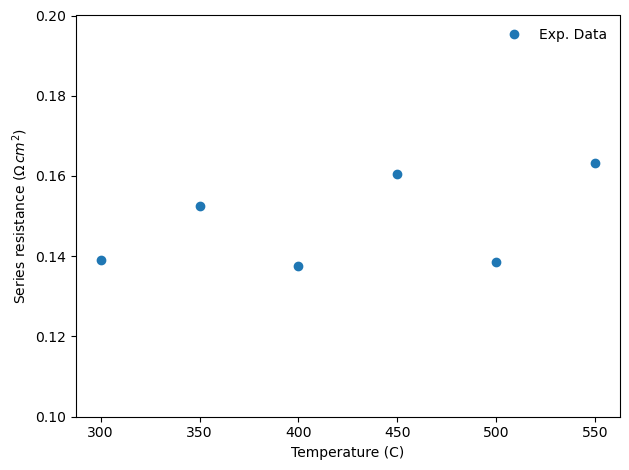

In [8]:
from scipy import stats
temperatures = np.array([(temp) for temp in folder_list])
x_axis = temperatures
y_axis = Rs
plt.plot(x_axis, y_axis*area, 'o', label='Exp. Data')
plt.legend(frameon=False)
plt.ylim(0.1,0.2)
plt.xlabel('Temperature (C)')
plt.ylabel('Series resistance ($\Omega\,cm^{2}$)')
plt.tight_layout()
plt.savefig("Rs.png",format="png",dpi=600)
plt.show()

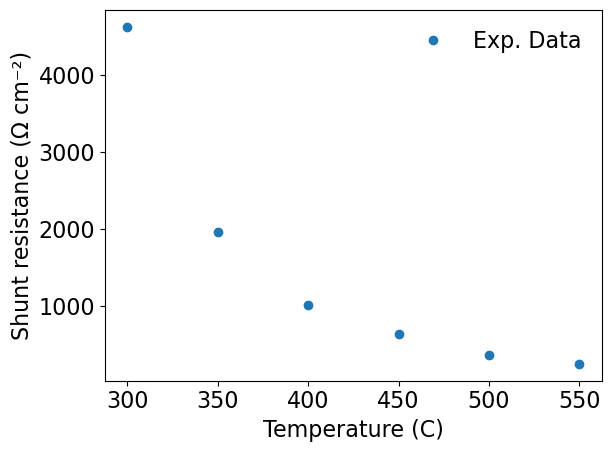

In [92]:
from scipy import stats
temperatures = np.array([(temp) for temp in folder_list])
x_axis = temperatures
y_axis = Rsh
plt.plot(x_axis, y_axis*area, 'o', label='Exp. Data')
plt.legend(frameon=False)
#plt.yscale("log")
plt.xlabel('Temperature (C)')
plt.ylabel('Shunt resistance (Ω cm⁻²)')
plt.tight_layout()
plt.savefig("Rsh.png",format="png",dpi=600)
plt.show()

In [6]:
temperature_list = [300,350,400,450,500,550]
for temp in temperature_list:
    iv_folder = "./D2_Temp/"+str(temp)+"C"+"/"
    iv_curves = [f for f in listdir(iv_folder) if isfile(join(iv_folder, f))]
    iv_filename = iv_curves[0]
    print(iv_curves)


['iv_curve_300.txt']
['iv_curve_350.txt']
['iv_curve_400.txt']
['iv_curve_450.txt']
['iv_curve_500.txt']
['iv_curve_550.txt']


C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\621384103.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(results_folder + "/" + results_file, delim_whitespace=True, header=0, dtype=float)
C:\Users\dfebba\AppData\Local\Temp\2\ipykernel_29624\62138

MAPE - 550C: 6.78 %
MAPE - 500C: 7.83 %
MAPE - 450C: 6.71 %
MAPE - 400C: 7.65 %
MAPE - 350C: 4.67 %
MAPE - 300C: 7.64 %


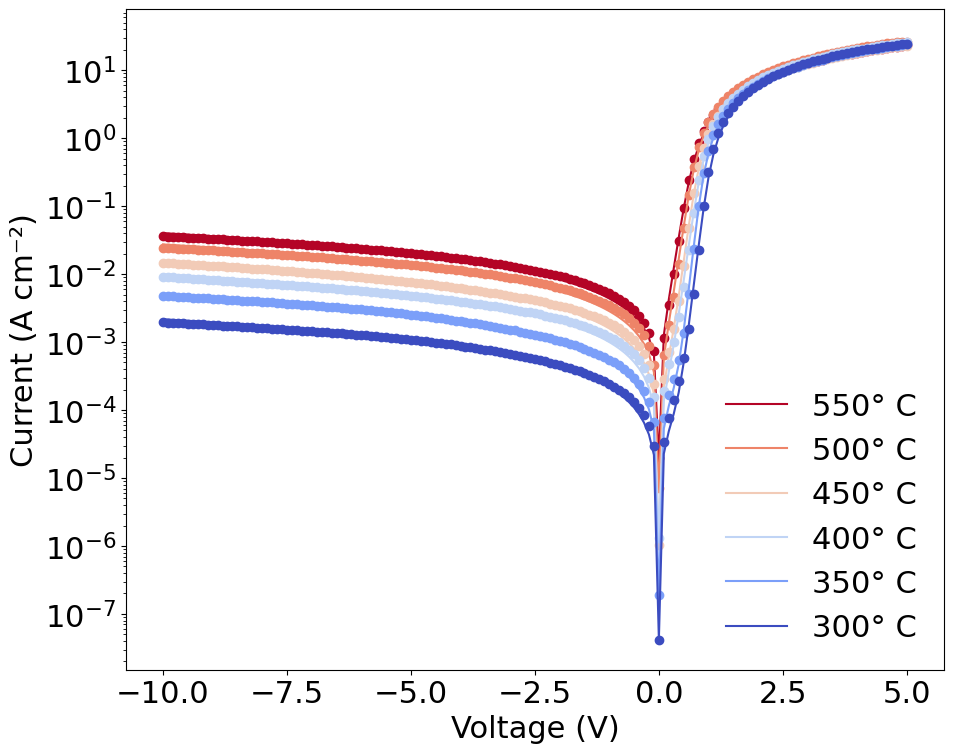

In [24]:
# %matplotlib qt
plt.rcParams.update({'font.size': 22})
from matplotlib import cm
from matplotlib.colors import Normalize
def plot_multiple_temperatures(temperature_list):
    norm = Normalize(vmin=min(temperature_list), vmax=max(temperature_list))
    smap = cm.coolwarm
    
    def lambert_result(temperature_celsius, iv_folder, iv_file, results_folder, results_file, plot=False,color='blue'):
        area = 3.14*(0.1/2)**2
        voltage, current = clean_raw_data(iv_folder, iv_file, vmin=-10, vmax=5)
        df = load_result_file(results_folder, results_file)
        best_result = df.loc[df['Objective'].idxmin()]
        charge = 1.60e-19
        boltz = 1.38e-23
        vt = boltz * (temperature_celsius + 273.15) / charge
        objective, i0, n, Rs, Rsh, offset = best_result
        indv = [i0, n, Rs, Rsh, offset]
        #print(best_result)
        adjusted_voltage = voltage + indv[4]
        term1 = 1.0 + indv[2] / indv[3]
        term2 = (indv[0] * indv[2]) / (indv[1] * vt * term1)
        term3 = (indv[2] * indv[0] + adjusted_voltage) / (indv[1] * vt * term1)  # V is now an array, so this operation is vectorized
        sim = (indv[1] * vt / indv[2]) * lambertw_newton(term2 * np.exp(term3)) - (indv[0] - adjusted_voltage / indv[3]) / term1
        mape = calculate_mape(sim,current)
        print(f"MAPE - {temperature_celsius}C: {mape:.2f} %")
        if plot:
            plt.plot(voltage,np.abs(current/area), 'o', color=color)
            plt.plot(voltage,np.abs(sim/area), '-' ,color = color, label = str(temperature_celsius) + u"\u00b0 C")
            plt.yscale("log")
            #plt.xlabel('Voltage (V)')
            #plt.ylabel('Current (A)')
            plt.legend(loc='upper left', frameon=False)
            #plt.show()

    

    plt.figure(figsize=(10, 8))
    for temp in temperature_list:
        iv_folder = "./D2_Temp/"+str(temp)+"C"+"/"
        iv_curves = [f for f in listdir(iv_folder) if isfile(join(iv_folder, f))]
        iv_filename = iv_curves[0]

        results_folder = iv_folder + "/Results"
        results_file = "Results_" + iv_filename

        vmin, vmax = -10, 5        
        color = smap(norm(temp))
        temperature_celsius = temp
        lambert_result(temperature_celsius, iv_folder, iv_filename, results_folder, results_file, plot=True, color=color)

    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A cm⁻²)')
    
    plt.legend(loc='lower right', frameon=False)
    #plt.ylim(1e-9,1e3)
    plt.tight_layout()
    plt.savefig('../LLM/Figures/IVT.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()    
    
temperature_list = list(reversed([300,350,400,450,500,550]))
plot_multiple_temperatures(temperature_list)    